In [1]:
from lsst_efd_client import EfdClient
from lsst.ts import salobj

import asyncio
import numpy as np
import os
import time

from astropy.io import fits
import matplotlib.pyplot as plt

from scipy import interpolate

from astropy.time import Time, TimeDelta
import pandas as pd

In [2]:
client = EfdClient('tucson_teststand_efd')

In [3]:
CenterScan_455nm_raw_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_2022-06-01T22:45:08.535.csv'
CenterScan_455nm_lens_filen ='/home/parfa30/DATA/ScanData/455nm_center_scan_led_lens_2022-06-01T22:59:15.834.csv'
CenterScan_455nm_lens_filen_2 ='/home/parfa30/DATA/ScanData/455nm_center_scan_led_lens_2_2022-06-01T23:38:09.884.csv'
CenterScan_455nm_lens_filen_3 ='/home/parfa30/DATA/ScanData/455nm_center_scan_led_lens_3_2022-06-02T00:26:30.649.csv'
FullScan_455nm_lens_filen ='/home/parfa30/DATA/ScanData/455nm_full_scan_led_lens_2022-06-01T23:30:11.668.csv'

In [4]:
C0_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_0mm_2022-06-03T17:15:21.501.csv'
C1_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_2mm_2022-06-03T17:36:40.160.csv'
C2_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_4mm_2022-06-03T17:48:26.481.csv'
C3_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_resolved_2022-06-03T18:00:53.754.csv'
C4_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_resolved_lens_2022-06-03T18:11:12.138.csv'
C5_filen = '/home/parfa30/DATA/ScanData/455nm_center_scan_led_0mm_lens_2022-06-03T18:22:24.036.csv'

In [5]:
import subprocess
dir_ = '/home/parfa30/DATA/electrometer_files'
def transfer_file(filen):
    bashCommand = "scp saluser@toonie.tu.lsst.org:/home/saluser/develop/electrometerFitsFiles/{} {}".format(filen, dir_)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

In [6]:
def get_y_func(stage_df):
    y = stage_df[stage_df.LinearStageID == 2]
    f = interpolate.interp1d(list(y.index.to_julian_date()), list(y['position']), fill_value='extrapolate',bounds_error=False)
    return f

In [7]:
pd_response = pd.read_csv('hamamatsu_responsivity.csv')
area = 100 #mm2
amps_per_watt = float(pd_response[pd_response.wavelength == 440].responsivity)                        
             
def watts_per_mm2(amps):  
    watts_per_mm2 = (amps/amps_per_watt)/area
    return watts_per_mm2         

In [293]:
test = '/home/parfa30/DATA/ScanData/455nm_test_2022-06-03T22:35:08.851.csv'
#test = '/home/parfa30/DATA/ScanData/600nm_stability_test_2022-06-03T22:02:49.631.csv'
f0 = pd.read_csv(test)
start = Time(min(f0.start_time))
end1 = Time(min(f0.end_time))
end = Time(max(f0.end_time))

In [294]:
stage_log_topic = 'lsst.sal.LinearStage.position'
stage_df = await client.select_time_series(stage_log_topic,['LinearStageID','position'],start=start, end=end)
stage_df.sort_index(inplace=True)

In [295]:
yy = stage_df[stage_df.LinearStageID == 2]

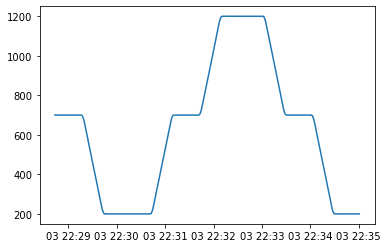

In [296]:
plt.plot(yy.position)

In [299]:
f = interpolate.interp1d(list(yy.index.to_julian_date()), list(yy['position']), fill_value='extrapolate',bounds_error=False)

In [3]:
def get_x_func(stage_df):
    x = stage_df[stage_df.LinearStageID == 1]
    f = interpolate.interp1d(list(x.index.to_julian_date()), list(x['position']), fill_value='extrapolate',bounds_error=False)
    return f

In [4]:
async def get_efd_data(start_time, end_time):
    elec_log_topic = 'lsst.sal.Electrometer.logevent_logMessage'
    elec_df = await client.select_time_series(elec_log_topic,['ElectrometerID','functionName','message'], start=start_time, end=end_time)
    elec_df.sort_index(inplace=True)
    stage_log_topic = 'lsst.sal.LinearStage.position'
    stage_df = await client.select_time_series(stage_log_topic,['LinearStageID','position'],start=start_time, end=end_time)
    stage_df.sort_index(inplace=True)
    
    return elec_df, stage_df

In [316]:
ScanData = pd.read_csv(test)
row = ScanData.iloc[3]
elec_df, stage_df = await get_efd_data(Time(row['start_time']),Time(row['end_time']))
x = elec_df[(elec_df.functionName == 'write_fits_file')]

In [317]:
x

,ElectrometerID,functionName,message
2022-06-03 22:32:11.405860+00:00,2,write_fits_file,Electrometer Scan data file written: 165429553...
2022-06-03 22:32:11.408285+00:00,2,write_fits_file,"Scan Summary of [Mean, median, std] is: [-6.22..."
2022-06-03 22:32:11.477840+00:00,4,write_fits_file,Electrometer Scan data file written: 165429553...
2022-06-03 22:32:11.480320+00:00,4,write_fits_file,"Scan Summary of [Mean, median, std] is: [-2.65..."
2022-06-03 22:32:11.531636+00:00,5,write_fits_file,Electrometer Scan data file written: 165429553...
2022-06-03 22:32:11.532762+00:00,5,write_fits_file,"Scan Summary of [Mean, median, std] is: [-3.55..."


In [318]:
x = x.iloc[0]

In [319]:
filen = x.message.split(' ')[-1]
start_time, end_time = os.path.splitext(filen)[0].split('_')
transfer_file(filen)

In [320]:
ff = os.path.join(dir_, filen)
data = fits.open(ff)[0].data

In [321]:
t1 = Time(float(start_time)-37, scale='tai',format='unix_tai')

In [322]:
t2 = Time(float(end_time)-37, scale='tai',format='unix_tai')

In [323]:
(t2-t1).datetime

datetime.timedelta(seconds=29, microseconds=807708)

In [324]:
times = data[0]+float(start_time)-37

In [325]:
tt = Time(times, scale='tai',format='unix_tai')

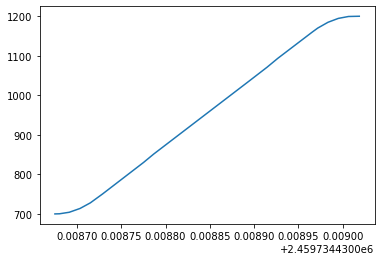

In [326]:
plt.plot(tt.jd, f(tt.jd))

In [313]:
t1.datetime, t2.datetime

(datetime.datetime(2022, 6, 3, 22, 28, 43, 256106),
 datetime.datetime(2022, 6, 3, 22, 28, 44, 833131))

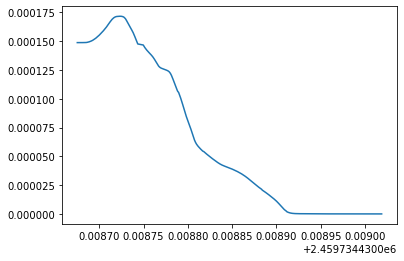

In [329]:
plt.plot(tt.jd,data[1][::-1]*-1)

In [ ]:
plt.plot(tt.jd, data[1])

In [17]:
x_offset = {2:0,4:-200,5:-400}

In [16]:
def get_elec_data(elec_df, y_pos_func, scan_row):
    x = elec_df[(elec_df.functionName == 'write_fits_file')]
    D = []
    for i, row in x.iterrows():
        if 'data file' in row.message:
            xpos = scan_row['xpos'] + x_offset[int(row['ElectrometerID'])]
            filen = row.message.split(' ')[-1]
            start_time, end_time = os.path.splitext(filen)[0].split('_')
            start = Time(float(start_time)-37, scale='tai',format='unix_tai').datetime
            end = Time(float(end_time)-37, scale='tai',format='unix_tai').datetime
            transfer_file(filen)
            ff = os.path.join(dir_, filen)
            data = fits.open(ff)[0].data
            for ii, t in enumerate(list(data[0])):
                tt = t + float(start_time) - 37
                tt = Time(tt, scale='tai',format='unix_tai')
                if isinstance(y_pos_func,float):
                    ypos = y_pos_func
                else:
                    ypos = y_pos_func(tt.jd)
            
                D.append([scan_row['start_time'],scan_row['end_time'],row['ElectrometerID'],filen, tt.datetime, xpos,ypos, np.array(data[1][::-1])[ii], scan_row['step'],scan_row['total_steps'],scan_row['test_name'], scan_row['wave']])
        
    return D

In [15]:
def get_elec_data_x(elec_df, x_pos_func, scan_row):
    x = elec_df[(elec_df.functionName == 'write_fits_file')]
    D = []
    for i, row in x.iterrows():
        if 'data file' in row.message:
            
            filen = row.message.split(' ')[-1]
            start_time, end_time = os.path.splitext(filen)[0].split('_')
            start = Time(float(start_time)-37, scale='tai',format='unix_tai').datetime
            end = Time(float(end_time)-37, scale='tai',format='unix_tai').datetime
            transfer_file(filen)
            ff = os.path.join(dir_, filen)
            data = fits.open(ff)[0].data
            for ii, t in enumerate(list(data[0])):
                tt = t + float(start_time) - 37
                tt = Time(tt, scale='tai',format='unix_tai')
                if isinstance(x_pos_func,float):
                    xpos = x_pos_func    
                else:
                    xpos = x_pos_func(tt.jd)
                    xpos = xpos + x_offset[int(row['ElectrometerID'])]
                D.append([scan_row['start_time'],scan_row['end_time'],row['ElectrometerID'],filen, tt.datetime, xpos,700, np.array(data[1])[ii], scan_row['test_name'], scan_row['wave']])
    return D

In [12]:
async def get_final_data(test_type, scan_filen, final_filen):
    ScanData = pd.read_csv(scan_filen)
    FinalData = []
    for i, row in ScanData.iterrows():
        try:
            elec_df, stage_df = await get_efd_data(Time(row['start_time']),Time(row['end_time']))
            if test_type == 'full':
                y_pos_func = get_y_func(stage_df) 
                D = get_elec_data(elec_df, y_pos_func, row)
                new_df = pd.DataFrame(D, columns = ['start_time','end_time','Electrometer','filename','meas_time','xpos','ypos','amps','step','total_steps','test_name','wave'])
            elif test_type == 'center':
                x_pos_func = get_x_func(stage_df) 
                D = get_elec_data_x(elec_df, x_pos_func, row)
                new_df = pd.DataFrame(D, columns = ['start_time','end_time','Electrometer','filename','meas_time','xpos','ypos','amps','test_name','wave'])
            elif test_type == 'stability':
                D = get_elec_data(elec_df, float(1000), row)
                new_df = pd.DataFrame(D, columns = ['start_time','end_time','Electrometer','filename','meas_time','xpos','ypos','amps','step','total_steps','test_name','wave'])
            FinalData.append(new_df)
        except:
            print('problem with efd',i)
            
    FinalData = pd.concat(FinalData)
    FinalData.reset_index(inplace=True)
    save_filen = '{}.csv'.format(final_filen)
    print(os.path.join('/home/parfa30/DATA/ScanData',save_filen))
    FinalData.to_csv(os.path.join('/home/parfa30/DATA/ScanData',save_filen),index=False)
    return FinalData

In [18]:
center_raw_455 = await get_final_data('center', CenterScan_455nm_raw_filen, '455nm_center_raw_jun1')                    

problem with efd 0
/home/parfa30/DATA/ScanData/455nm_center_raw_jun1.csv


In [19]:
center_lens_455 = await get_final_data('center', CenterScan_455nm_lens_filen_3, '455nm_center_raw_jun1') 

problem with efd 1
/home/parfa30/DATA/ScanData/455nm_center_raw_jun1.csv


In [20]:
C0 = await get_final_data('center', C0_filen, '455nm_center_raw_0mm_jun3') 

problem with efd 1
/home/parfa30/DATA/ScanData/455nm_center_raw_0mm_jun3.csv


In [21]:
C1 = await get_final_data('center', C1_filen, '455nm_center_raw_2mm_jun3') 

problem with efd 1
/home/parfa30/DATA/ScanData/455nm_center_raw_2mm_jun3.csv


In [5]:
C1 = pd.read_csv('/home/parfa30/DATA/ScanData/455nm_center_raw_2mm_jun3.csv')

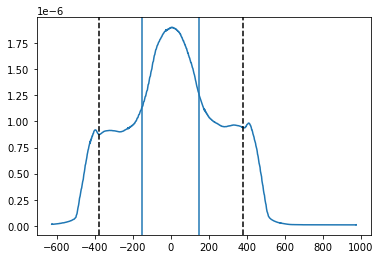

In [9]:
plt.plot(C1.xpos-825, watts_per_mm2(C1.amps*-1))
plt.axvline(-378,c='k',ls='--',label='reflector')
plt.axvline(378,c='k',ls='--')
plt.axvline(-150)
plt.axvline(150)

In [11]:
xx = C1.xpos-825
yy = watts_per_mm2(C1.amps*-1)

In [15]:
C1['xpos_'] = C1.xpos-825
x1 = C1[(C1['xpos_']>-378)&(C1['xpos_']<-150)]
x2 = C1[(C1['xpos_']<378)&(C1['xpos_']>150)]
c = np.mean([x1.amps.sum(), x2.amps.sum()])

In [16]:
watts_per_mm2(c*2*np.pi*-1)

0.0021782967434082726

In [32]:
f = interpolate.interp1d(xx, yy, fill_value=0,bounds_error=False)

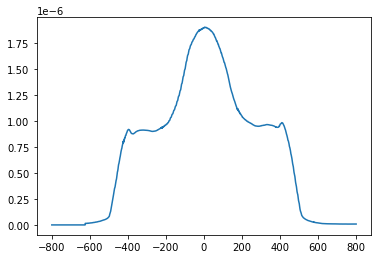

In [43]:
newx = np.linspace(-800,800,10*1600)
plt.plot(newx, f(newx))

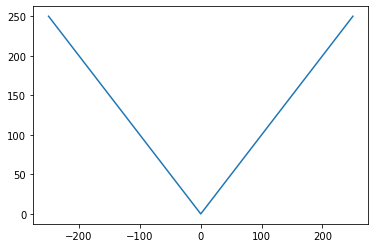

In [68]:
plt.plot(xxx,1.0001*np.abs(xxx)+1e-6)

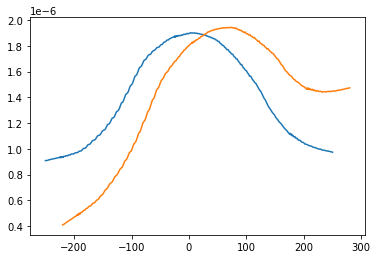

In [80]:
xxx = newx[np.where(np.abs(newx)<250)]
plt.plot(xxx, f(xxx))
plt.plot(xxx+30, f(xxx)+2e-9*xxx)

In [133]:
x1 = newx[np.where(newx<250)]
f1 = f(x1)
x2 = newx[np.where(np.abs(newx)<150)]
print(len(x2))
f2 = f(x2)+2e-9*x2
print(len(f2))
x3 = newx[np.where(newx>250)]
f3 = f(x3)

3000
3000


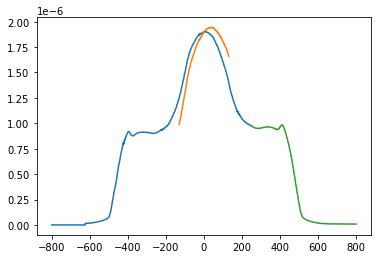

In [134]:
plt.plot(x1, f1)
plt.plot(x2[200:-200],f2[200:-200])
plt.plot(x3,f3)

In [144]:
ix = np.where((newx<150)&(newx>-150))
ff = f(newx)
ixx = np.where((x2<150)&(x2>-150))
print(len(ix[0]),len(f2[ixx]))
ff[ix] = f2[ixx]

3000 3000


In [153]:
kernel_size = 500
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(ff, kernel, mode='same')

Text(0, 0.5, '$W/mm^{2}$')

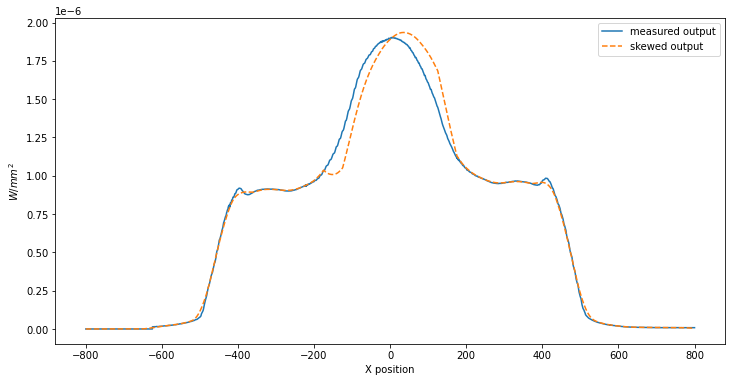

In [157]:
plt.figure(figsize=(12,6))
plt.plot(newx,f(newx),label='measured output')
#plt.plot(newx, ff,'--',label='skewed output')
plt.plot(newx, data_convolved,'--',label='skewed output')
plt.legend()
plt.xlabel("X position")
plt.ylabel('$W/mm^{2}$')


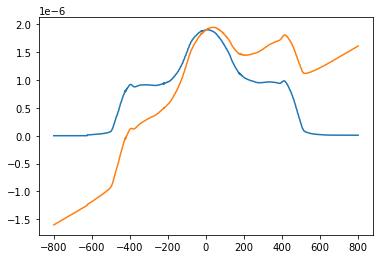

In [78]:
plt.plot(newx, f(newx))
plt.plot(newx, f(newx)+2e-9*newx)

In [156]:
#df = pd.DataFrame([[newx, f(newx)]].T, columns=['X','W/mm2'])
df.to_csv('led_output_skewed.csv',index=False)

In [155]:
df = pd.DataFrame()
df['X'] = newx
df['W/mm2'] = data_convolved

In [44]:
df = pd.DataFrame()
df['X'] = newx
df['W/mm2'] = f(newx)

In [41]:
df.head()

,X,W/mm2
0,-800.000000,0.0
1,-767.346939,0.0
2,-734.693878,0.0
3,-702.040816,0.0
4,-669.387755,0.0


In [ ]:
C2 = await get_final_data('center', C2_filen, '455nm_center_raw_4mm_jun3') 

In [ ]:
C3 = await get_final_data('center', C3_filen, '455nm_center_raw_resolved_jun3') 

In [ ]:
C4 = await get_final_data('center', C4_filen, '455nm_center_raw_resolved_lens_jun3') 

In [ ]:
C5 = await get_final_data('center', C5_filen, '455nm_center_raw_0mm_lens_jun3') 

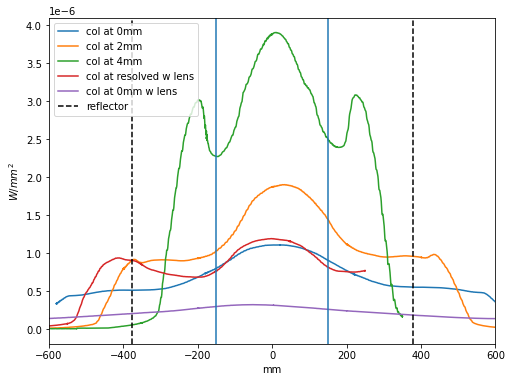

In [349]:
plt.figure(figsize=(8,6))
plt.plot(C0.xpos-780, watts_per_mm2(C0.amps*-1),label='col at 0mm')
plt.plot(C1.xpos-800, watts_per_mm2(C1.amps*-1),label='col at 2mm')
plt.plot(C2.xpos-1250, watts_per_mm2(C2.amps*-1),label='col at 4mm')
#plt.plot(C3.xpos-925, watts_per_mm2(C3.amps*-1),label='col at resolved')
plt.plot(C4.xpos-1350, watts_per_mm2(C4.amps*-1),label='col at resolved w lens')
plt.plot(C5.xpos-800, watts_per_mm2(C5.amps*-1),label='col at 0mm w lens')
plt.xlim(-600,600)
plt.ylabel('$W/mm^{2}$')
plt.xlabel('mm')
plt.axvline(-378,c='k',ls='--',label='reflector')
plt.axvline(378,c='k',ls='--')
plt.axvline(-150)
plt.axvline(150)
plt.legend()

In [ ]:
for e in [2,4,5]:
    xx = center_raw_455[center_raw_455.Electrometer == e]
    plt.plot(xx.xpos, xx.amps*-1, label=e)
plt.legend()

In [ ]:
for e in [2,4,5]:
    xx = center_lens_455[center_lens_455.Electrometer == e]
    plt.plot(xx.xpos, xx.amps*-1, label=e)
plt.axvline(1250-378)
plt.axvline(1250+378)
plt.legend()

In [339]:
full_lens_455 = await get_final_data('full', FullScan_455nm_lens_filen,'455nm_led_full_scan_jun1')

problem with efd 0
/home/parfa30/DATA/ScanData/455nm_led_full_scan_jun1.csv


In [340]:
f0 = full_lens_455[full_lens_455.amps < 0]

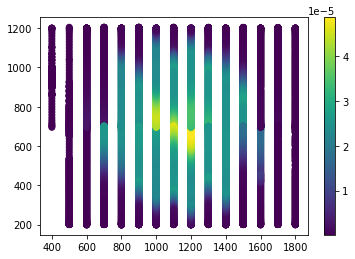

In [341]:
plt.scatter(f0.xpos,f0.ypos,c=f0.amps*-1)
plt.colorbar()

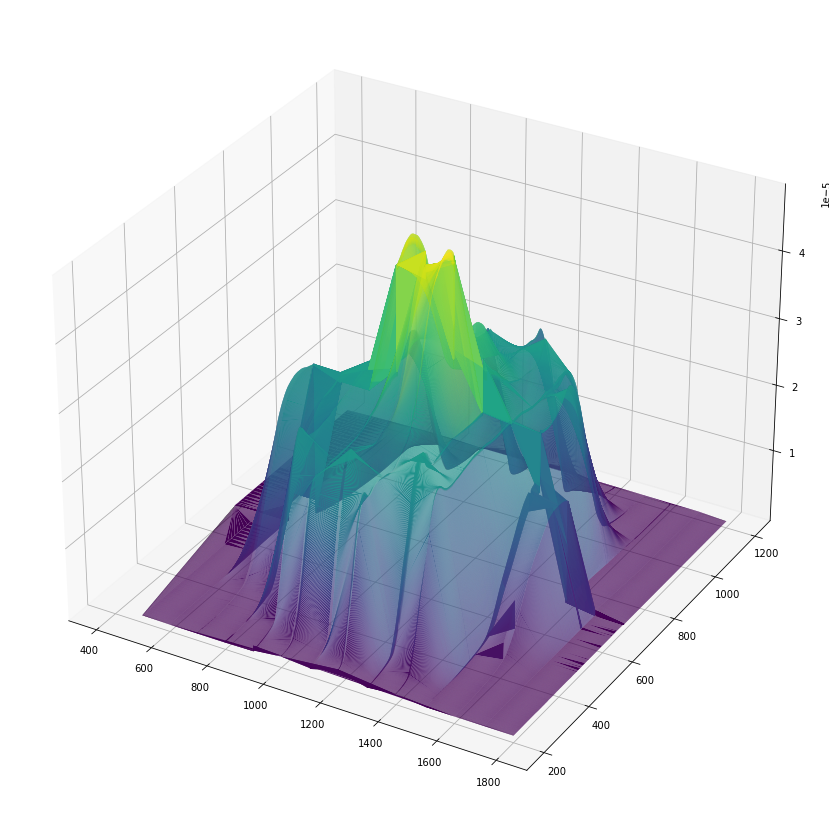

In [343]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.plot_trisurf(f0.xpos,f0.ypos, f0.amps*-1,cmap = 'viridis')

In [ ]:
from scipy import stats

In [344]:
test_name = [600,600,600]
for i,test in enumerate([f0]):
    x = test.xpos
    y = test.ypos
    binx = np.linspace(800,1500,(1500-800)//10)
    biny = np.linspace(300,1100,(1100-300)//10)
    val,xedge,yedge,binn = stats.binned_statistic_2d(x, y, test.amps*-1, 'mean', bins=[binx, biny])
    plt.figure(figsize=(5,5))
    xx,yy = np.meshgrid(xedge[:-1],yedge[:-1])
    plt.scatter(xx,yy,c=val.T,s=100)
    plt.title('{}nm'.format(test_name[i]))
    plt.subplots(figsize=(10,10))
    ax = plt.axes(projection = '3d')
    ax.plot_surface(xx,yy,val.T,cmap = 'viridis')
    ax.set_title('{}nm'.format(test_name[i]))
    xxx = xx.flatten()
    yyy = yy.flatten()
    zzz = val.T.flatten()

    center_y = np.where(np.abs(yyy-700)<20)
    center_x = np.where(np.abs(xxx-1170)<20)
    plt.figure()
    plt.plot(xxx[center_y]-1170, zzz[center_y],'x',label='Y center')
    plt.plot(yyy[center_x]-700, zzz[center_x],'x', label='X center')
    plt.axvline(-100)
    plt.axvline(100)
    plt.title('{}nm'.format(test_name[i]))
    plt.legend()

NameError: name 'stats' is not defined